In [ ]:
"""
考量營運限制之模型 heuristic、甘特圖繪製程式碼
"""

In [1]:
import pandas as pd
import random
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import platform
 # flights param
NUM_GATES = 52

#GA param
"""
POPULATION_SIZE = 100
MUTATION_RATE = 0.01
CROSSOVER_RATE = 0.7
GENERATIONS = 1000
"""

'\nPOPULATION_SIZE = 100\nMUTATION_RATE = 0.01\nCROSSOVER_RATE = 0.7\nGENERATIONS = 1000\n'

In [2]:
class flight:
    def __init__(self, id, A_i, S_i, U_i, Y, size, B, number):
        self.id = id
        self.A_i = A_i
        self.S_i = S_i
        self.U_i = U_i
        self.Y = Y
        self.size = size
        self.B = B
        self.G = None
        self.t_i = None # 開始服務時間
        self.y = None   #後來被派去的登機門
        self.number = number

In [3]:
# 目前有兩種移動方式：1. 交換兩個航班的登機門 2. 將停機坪的航班移到登機門
# 未來可以新增的：
# 1. 可以再新增如果過了幾步還是no improvement，就回到目前最佳解繼續搜尋
# 2. 或許可以限制他每次只能交換鄰近的登機門？
class TabuSearch:
    def __init__(self, flights, N, Wij, tabu_size=15, iterations=1000, candidate_size=20, move_prob=0.3):
        self.flights = flights
        self.N = N
        self.Wij = Wij
        self.tabu_list = []
        self.tabu_size = tabu_size  # 禁忌列表的長度
        self.iterations = iterations
        self.candidate_size = candidate_size 
        self.move_prob = move_prob  # 執行從停機坪移動出來的機率
        self.M = 100000 

        initial_solution = self.generate_initial_solution()
        self.best_cost = self.calculate_cost(initial_solution)
        
        self.best_assignment = copy.deepcopy(initial_solution)
        self.current_assignment = copy.deepcopy(initial_solution)
        self.current_cost = self.best_cost
    
    def calculate_cost(self, assignments):
        processed_assignments = {key:[] for key in range(1, NUM_GATES + 1)}
        total_delay = 0

        # calculate delay, gate changing and apron penalty
        for gate_idx, value in assignments.items():
            if not value: continue
            
            value.sort(key=lambda x: x.U_i)
            current_time = value[0].U_i

            for flight in value:
                start_service_time = max(current_time, flight.U_i)
                end_service_time = start_service_time + flight.S_i

                processed_assignments[gate_idx].append((flight, start_service_time, end_service_time))

                total_delay += start_service_time - flight.U_i
                if gate_idx != flight.Y:
                    total_delay += self.Wij.loc[flight.Y, str(gate_idx)]
                if gate_idx > 37:   # 38 ~ 52 是停機坪
                    total_delay += flight.B

                current_time = end_service_time

        # calculate penalty for L size flights next to XL size flights
        for gate_idx, assigned_flights in processed_assignments.items():
            if gate_idx > 37: continue  # 停機坪暫時不考慮飛機大小的限制
            for (xl_flight, xl_start, xl_end) in assigned_flights: 
                if xl_flight.size == "XL":
                    if gate_idx - 1 < len(self.N):
                        nearby_gates = self.N[gate_idx - 1]
                        flag = False
                        for nearby_gate_idx in nearby_gates:
                            for (neighbor_flight, neighbor_start, neighbor_end) in processed_assignments[nearby_gate_idx]:
                                if neighbor_flight.size in ["L", "XL"]:
                                    if max(xl_start, neighbor_start) < min(xl_end, neighbor_end):
                                        total_delay += self.M
                                        flag = True
                                        break 
                            if flag: break
        return total_delay
    
    def generate_initial_solution(self):
        assignments = {key:[] for key in range(1, NUM_GATES + 1)}
        for flight in self.flights:
            assignments[flight.Y].append(flight)
        return assignments

    def get_random_swap_pair(self):
        max_attempts = 100
        for _ in range(max_attempts):
            f1_proto, f2_proto = random.sample(self.flights, 2)
            f1_id, f2_id = f1_proto.id, f2_proto.id
            
            f1_gate = None
            f2_gate = None

            # 尋找目前的登機門
            for gate, assigned_flights in self.current_assignment.items():
                for f in assigned_flights:
                    if f.id == f1_id: f1_gate = gate
                    elif f.id == f2_id: f2_gate = gate
                if f1_gate is not None and f2_gate is not None: break
            
            if f1_gate is not None and f2_gate is not None and f1_gate != f2_gate:
                # 檢查 G 限制
                if (f1_gate in f2_proto.G or f1_gate > 37) and (f2_gate in f1_proto.G or f2_gate > 37):
                    return f1_id, f2_id, f1_gate, f2_gate
        
        return None, None, None, None

    # 隨機尋找一個從停機坪移出的移動
    def get_random_apron_move(self):
        apron_flights = []
        for gate, flights in self.current_assignment.items():
            if gate > 37:
                for f in flights:
                    apron_flights.append((f, gate))
        
        if not apron_flights:
            return None, None, None
        
        flight_obj, old_gate = random.choice(apron_flights)
        
        # 確保 g 在 1 到 37 之間 (因為 assignments 的 key 是 1~52)
        valid_gates = [g for g in flight_obj.G if 1 <= g <= 37]
        
        if not valid_gates:
            return None, None, None
            
        new_gate = random.choice(valid_gates)
        return flight_obj.id, old_gate, new_gate

    # 進行移動，並計算移動後的成本
    def simulate_move_cost(self, flight_id, old_gate, new_gate):
        temp_assignment = copy.deepcopy(self.current_assignment)
        
        # 從舊登機門移除
        obj_to_move = None
        for i, f in enumerate(temp_assignment[old_gate]):
            if f.id == flight_id:
                obj_to_move = temp_assignment[old_gate].pop(i)
                break
        
        if obj_to_move:
            # 加入新登機門
            temp_assignment[new_gate].append(obj_to_move)
            return self.calculate_cost(temp_assignment), temp_assignment
        else:
            return float('inf'), None

    def simulate_swap_cost(self, f1_id, f2_id, f1_gate, f2_gate):
        temp_assignment = copy.deepcopy(self.current_assignment)
        
        def pop_by_id(lst, fid):
            for i, f in enumerate(lst):
                if f.id == fid: return lst.pop(i)
            return None

        obj1 = pop_by_id(temp_assignment[f1_gate], f1_id)
        obj2 = pop_by_id(temp_assignment[f2_gate], f2_id)
        
        if obj1 and obj2:
            temp_assignment[f1_gate].append(obj2)
            temp_assignment[f2_gate].append(obj1)
            return self.calculate_cost(temp_assignment), temp_assignment
        else:
            return float('inf'), None

    def optimize(self):
        print(f"Initial cost: {self.current_cost}")

        for i in range(self.iterations):
            best_candidate_move = None
            best_candidate_cost = float('inf')
            best_candidate_assignment = None
            
            # 每一輪產生多個候選解 (包含 Swap 和 Move)
            for _ in range(self.candidate_size):
                is_move_operation = False
                
                # 根據機率決定是做 Move 還是 Swap
                if random.random() < self.move_prob:
                    # 嘗試從停機坪移動出來
                    f_id, old_gate, new_gate = self.get_random_apron_move()
                    if f_id is not None:
                        cost, temp_assignment = self.simulate_move_cost(f_id, old_gate, new_gate)
                        # Move 的 Tabu 簽名：記錄 (flight_id, 'move_to', new_gate)
                        move_signature = (f_id, 'move_to', new_gate)
                        is_move_operation = True
                    else:
                        # 如果沒有停機坪航班可移動，退回做 Swap
                        cost = float('inf')
                else:
                    # 執行交換
                    f1_id, f2_id, f1_gate, f2_gate = self.get_random_swap_pair()
                    if f1_id is not None:
                        cost, temp_assignment = self.simulate_swap_cost(f1_id, f2_id, f1_gate, f2_gate)
                        move_signature = tuple(sorted([f1_id, f2_id]))
                    else:
                        cost = float('inf')

                if cost == float('inf'): continue

                # 檢查 Tabu 狀態
                is_tabu = move_signature in self.tabu_list
                
                # Aspiration Criteria (渴望準則): 如果是 Tabu 但比目前全域最佳還好，則允許
                if is_tabu and cost < self.best_cost:
                    is_tabu = False 

                if not is_tabu:
                    if cost < best_candidate_cost:
                        best_candidate_cost = cost
                        best_candidate_move = move_signature
                        best_candidate_assignment = temp_assignment

            if best_candidate_assignment is not None:
                self.current_assignment = best_candidate_assignment
                self.current_cost = best_candidate_cost
                
                self.tabu_list.append(best_candidate_move)
                if len(self.tabu_list) > self.tabu_size:
                    self.tabu_list.pop(0)

                if self.current_cost < self.best_cost:
                    self.best_cost = self.current_cost
                    self.best_assignment = copy.deepcopy(self.current_assignment)
                    print(f"Iteration {i+1} [NEW BEST]: {self.best_cost}")
                else:
                    if (i+1) % 50 == 0:
                        print(f"Iteration {i+1}: Current={self.current_cost}, Best={self.best_cost}")

In [4]:
# 基因演算法
"""
還沒改的部分：
1. 畫出來的圖怪怪的，要再看是發生什麼事
2. 後來有更新新的flight.csv還有wij.csv，不再把停機坪當作無限容量和馬上被服務了
"""
class GA:
    def __init__(self, population_size, mutation_rate, crossover_rate, generations, flights, N, Wij):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.generations = generations
        self.flights = flights
        self.N = N
        self.Wij = Wij

        self.population = []
        self.M = 100000

    def initializepopulation(self):
        for _ in range(self.population_size):
            individual = []
            for flight in self.flights:
                random_gate = random.choice(flight.G)
                individual.append(random_gate)
            self.population.append(individual)

    
    def fitness(self):
        fitness_scores = []
        for idx, individual in enumerate(self.population):
            # create assignments dict
            assignments = {key:[] for key in range(0, NUM_GATES + 1)}
            for flight, gate in zip (self.flights, individual):
                assignments[gate].append(flight)

            # calculate fitness: t_i - A_i + Wij + B_i
            total_delay = 0
            processed_assignments = {key:[] for key in range(0, NUM_GATES + 1)}
            for gate_idx, value in assignments.items():
                value.sort(key=lambda x: x.U_i) # 按照更新後抵達時間來排序
                current_time = value[0].U_i if value else 0

                for flight in value:
                    start_service_time = max(current_time, flight.U_i)
                    end_service_time = start_service_time + flight.S_i

                    processed_assignments[gate_idx].append((flight, start_service_time, end_service_time))

                    # calculate delay: t_i - A_i + Wij + B_i
                    total_delay += start_service_time - flight.A_i
                    if gate_idx != flight.Y:
                        total_delay += self.Wij.loc[flight.Y, str(gate_idx)]
                    if gate_idx == 0:
                        total_delay += flight.B

                    current_time = end_service_time # 更新登機門空閒時間

            # add constraint: only S size flights can be assigned next to XL size flights
            # if the constraint is violated, add a penalty M to the fitness score
            for gate_idx, assigned_flights in processed_assignments.items():
                if gate_idx == 0:
                    continue

                # assigned_flights 現在是 [(flight, start, end), ...]
                for (xl_flight, xl_start, xl_end) in assigned_flights: 
                    if xl_flight.size == "XL":
                        nearby_gates = self.N[gate_idx - 1] # N 是 0-indexed
                        flag = False

                        for nearby_gate_idx in nearby_gates:
                            # 檢查相鄰登機門的飛機
                            for (neighbor_flight, neighbor_start, neighbor_end) in processed_assignments[nearby_gate_idx]:
                                if neighbor_flight.size in ["L", "XL"]:
                                    # 檢查時間是否有重疊 (使用正確的 start/end time)
                                    if max(xl_start, neighbor_start) < min(xl_end, neighbor_end):
                                        total_delay += self.M
                                        flag = True
                                        break 
                            if flag:
                                break

            fitness_scores.append((idx, total_delay))

        return fitness_scores

    def selection(self, fitness_scores):
        # Select parents for crossover
        """
        # 輪盤選擇法
        epsilon = 1e-6
        selected = random.choices(self.population, weights=[1/(f[1]+epsilon) for f in fitness_scores],
                                  k=self.population_size)
        """
        # Tournament Selection (錦標賽選擇法)
        selected = []
        tournament_size = 5  # 可調整的參數：每次從幾個個體中挑選最好的

        # 將 fitness_scores 轉為字典 (map)，以便 O(1) 快速查詢
        # fitness_scores 是 [(idx, score), ...]
        fitness_map = {idx: score for idx, score in fitness_scores}

        for _ in range(self.population_size):
            # 1. 隨機挑選 k (tournament_size) 個個體的 "索引"
            tournament_contenders_indices = random.sample(range(self.population_size), tournament_size)
            
            # 2. 找到這 k 個個體中 fitness 最好 (delay 最低) 的那一個索引
            winner_idx = min(tournament_contenders_indices, 
                             key=lambda idx: fitness_map[idx])
            
            # 3. 將勝出的個體 (population[winner_idx]) 加入到選拔列表中
            selected.append(self.population[winner_idx])
            
        return selected
    
    def crossover(self, parent1, parent2):
        if random.random() < self.crossover_rate:
            point = random.randint(1, len(parent1) - 1)
            child1 = parent1[:point] + parent2[point:]
            child2 = parent2[:point] + parent1[point:]
            return child1, child2
        else:
            return parent1, parent2
    
    def mutate(self, individual):
        for i in range(len(individual)):
            if random.random() < self.mutation_rate:
                flight = self.flights[i]
                individual[i] = random.choice(flight.G)
        return individual

    def optimize(self):
        self.initializepopulation()

        global_best_individual = None
        global_best_fitness = float('inf')

        for generation in range(self.generations):
            fitness_scores = self.fitness()

            current_best_idx, current_best_fitness = min(fitness_scores, key=lambda x: x[1])
            if current_best_fitness < global_best_fitness:
                global_best_fitness = current_best_fitness
                # 必須使用 [:] 進行深度複製，否則 global_best_individual 會被後續的 mutate 操作污染
                global_best_individual = self.population[current_best_idx][:]
            if generation % 10 == 0:
               print(f"Generation {generation}: Best fitness score: {global_best_fitness}")

            selected = self.selection(fitness_scores)
            next_generation = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[i+1]
                child1, child2 = self.crossover(parent1, parent2)
                next_generation.append(self.mutate(child1))
                next_generation.append(self.mutate(child2))

            # 隨機選一個，替換成目前的全局最佳染色體
            replace_idx = random.randint(0, self.population_size - 1)
            next_generation[replace_idx] = global_best_individual[:]

            self.population = next_generation
            
        return global_best_individual, global_best_fitness
            

In [4]:
def generate_result_csv(assignments: dict, filename: str = 'results.csv'):
    result_list = []

    for assignment_gate_idx, assigned_flights in assignments.items():
        # 更新各個航班的開始服務時間
        if not assigned_flights:
            continue

        assigned_flights.sort(key=lambda x: x.U_i)
        current_time = assigned_flights[0].U_i if assigned_flights else 0

        for flight in assigned_flights:
            start_service_time = max(current_time, flight.U_i)
            end_service_time = start_service_time + flight.S_i
            result_row = {
            '航班ID': flight.id,
            '原始指派': flight.Y,
            '最新指派': assignment_gate_idx,
            '更新後抵達時間': flight.U_i,
            '作業開始時間': round(start_service_time, 2),
            '作業結束時間': round(end_service_time, 2),
            '班號': flight.number
            # '更換登機門成本': round(z[i].X, 2)
            }
            result_list.append(result_row)
            current_time = end_service_time

    # save result as a csv file
    result_list.sort(key=lambda x: x['航班ID'])
    try:
        results_df = pd.DataFrame(result_list)
        results_df.to_csv(filename, index=False, encoding='utf-8')
        print("-" * 100)
        print(f"result saved to: {filename}")
    except Exception as e:
        print(e) 

In [15]:
def draw_gantt(csv_file='results.csv', output_file='gantt_chart.png'):
    try:
        df = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"錯誤：找不到 '{csv_file}' 檔案。")

    else:
        
        df['gate_numeric'] = df['最新指派'] 
        df = df[df['gate_numeric'] != 0]
        
        df = df.sort_values(by=['gate_numeric', '作業開始時間'], ascending=[True, True])

        sys_os = platform.system()
        if sys_os == "Windows":
            plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
        elif sys_os == "Darwin":
            plt.rcParams['font.sans-serif'] = ['Heiti TC']
        else:
            plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Zen Hei'] 

        plt.rcParams['axes.unicode_minus'] = False

        fig, ax = plt.subplots(figsize=(30, 18)) 

        gate_numbers = sorted(df['gate_numeric'].unique())
        gate_to_y_pos = {gate: i for i, gate in enumerate(gate_numbers)}
        y_pos = np.arange(len(gate_numbers))

        # 顏色設定
        unique_flights = df['航班ID'].unique()
        num_flights = len(unique_flights)

        try:
            cmap = matplotlib.colormaps['viridis']
        except:
            cmap = plt.get_cmap('viridis')
            
        colors_list = cmap(np.linspace(0, 1, num_flights))
        flight_colors = {fid: colors_list[i] for i, fid in enumerate(unique_flights)}

        for index, task in df.iterrows():
            start = task['作業開始時間']
            end = task['作業結束時間']
            duration = end - start
            gate_num = task['gate_numeric']
            
            if gate_num not in gate_to_y_pos:
                continue
                
            y = gate_to_y_pos[gate_num]
            
            bar_color = flight_colors[task['航班ID']]
            brightness = (bar_color[0]*0.299 + bar_color[1]*0.587 + bar_color[2]*0.114)
            text_color = 'white' if brightness < 0.5 else 'black'

            ax.barh(
                y, 
                duration, 
                left=start, 
                height=1, 
                align='center',
                color=bar_color,
                edgecolor='black',
                alpha=0.9
            )
            
            ax.text(
                start + duration / 2, 
                y, 
                str(task['班號']), 
                ha='center', 
                va='center',
                color=text_color,
                fontweight='bold',
                fontsize=9
            )

        ax.set_yticks(y_pos)
        ytick_labels = [f"Gate {g}" if g != 0 else "Apron (0)" for g in gate_numbers]
        ax.set_yticklabels(ytick_labels, fontsize=10)


        ax.invert_yaxis() 
        
        ax.set_xlabel('Time (mins)', fontsize=14)
        ax.set_ylabel('Gate Assignment', fontsize=14)
        ax.set_title('Gate Assignment Result (Gantt Chart)', fontsize=18, fontweight='bold')

        max_time = df['作業結束時間'].max()
        ax.set_xticks(np.arange(0, max_time + 60, 30)) # 每30分鐘一格
        ax.tick_params(axis='x', rotation=45)

        ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.5, alpha=0.7)

        plt.tight_layout()

        plt.savefig(output_file, dpi=300)
        print(f"甘特圖已成功儲存至檔案: {output_file}")
        plt.show()

In [7]:
# 登機門編號：1 ~ 37，38 ~ 52代表停機坪

# process flight data
df = pd.read_csv("flight.csv")
flights = []
for idx, row in df.iterrows():
    Y = row["original_gate"]    # 預指派登機門
    size = None

    for i in ["S", "L", "XL"]:
        if row[i] == 1:
            size = i
            break

    if Y == None or size is None:
        raise ValueError(f"Invalid flight data: flight {row['flight_id']} is missing Y or size")

    flights.append(flight(
        id=row['flight_id'],
        A_i=row['A_i'],
        S_i=row['S_i'],
        U_i=row['U_i'],
        Y=Y,
        size=size,
        B=row['B'],
        number=row["flight_number"]
    ))

# process Gij: allowed gates j for each flight i
df = pd.read_csv("./data/Gij.csv")
for idx, row in df.iterrows():
    G_list = [0]  # gate 0 represents apron
    for i in range(1, 38):
        if row[f"gate_{i}"] == 1:
            G_list.append(i)
    flights[idx].G = G_list

# process Nij: =1 if gate j is neighboring gate i
df = pd.read_csv("./data/Nij.csv")
N = []
for idx, row in df.iterrows():
    N.append([])
    for i in range(1, 38):
        if row[f"{i}"] == 1:
            N[-1].append(i)

# process Wij: penalty cost matrix for assigning flight from gate i to gate j
Wij = pd.read_csv("./data/Wij.csv", index_col=0)

# use GA to optimize，但好像還沒寫好？圖有點怪怪的
"""
GA_instance = GA(
    population_size=POPULATION_SIZE,
    mutation_rate=MUTATION_RATE,
    crossover_rate=CROSSOVER_RATE,
    generations=GENERATIONS,
    flights=flights,
    N=N,
    Wij=Wij
)
best_individual, best_fitness = GA_instance.optimize()
print("Best assignment:", best_individual)
print("Best fitness score (total delay):", best_fitness)
"""

'\nGA_instance = GA(\n    population_size=POPULATION_SIZE,\n    mutation_rate=MUTATION_RATE,\n    crossover_rate=CROSSOVER_RATE,\n    generations=GENERATIONS,\n    flights=flights,\n    N=N,\n    Wij=Wij\n)\nbest_individual, best_fitness = GA_instance.optimize()\nprint("Best assignment:", best_individual)\nprint("Best fitness score (total delay):", best_fitness)\n'

Initial cost: 5097
Initial number of flights assigned to apron: 57
----------------------------------------------------------------------------------------------------
result saved to: initial_results.csv
甘特圖已成功儲存至檔案: initial_gantt_chart.png


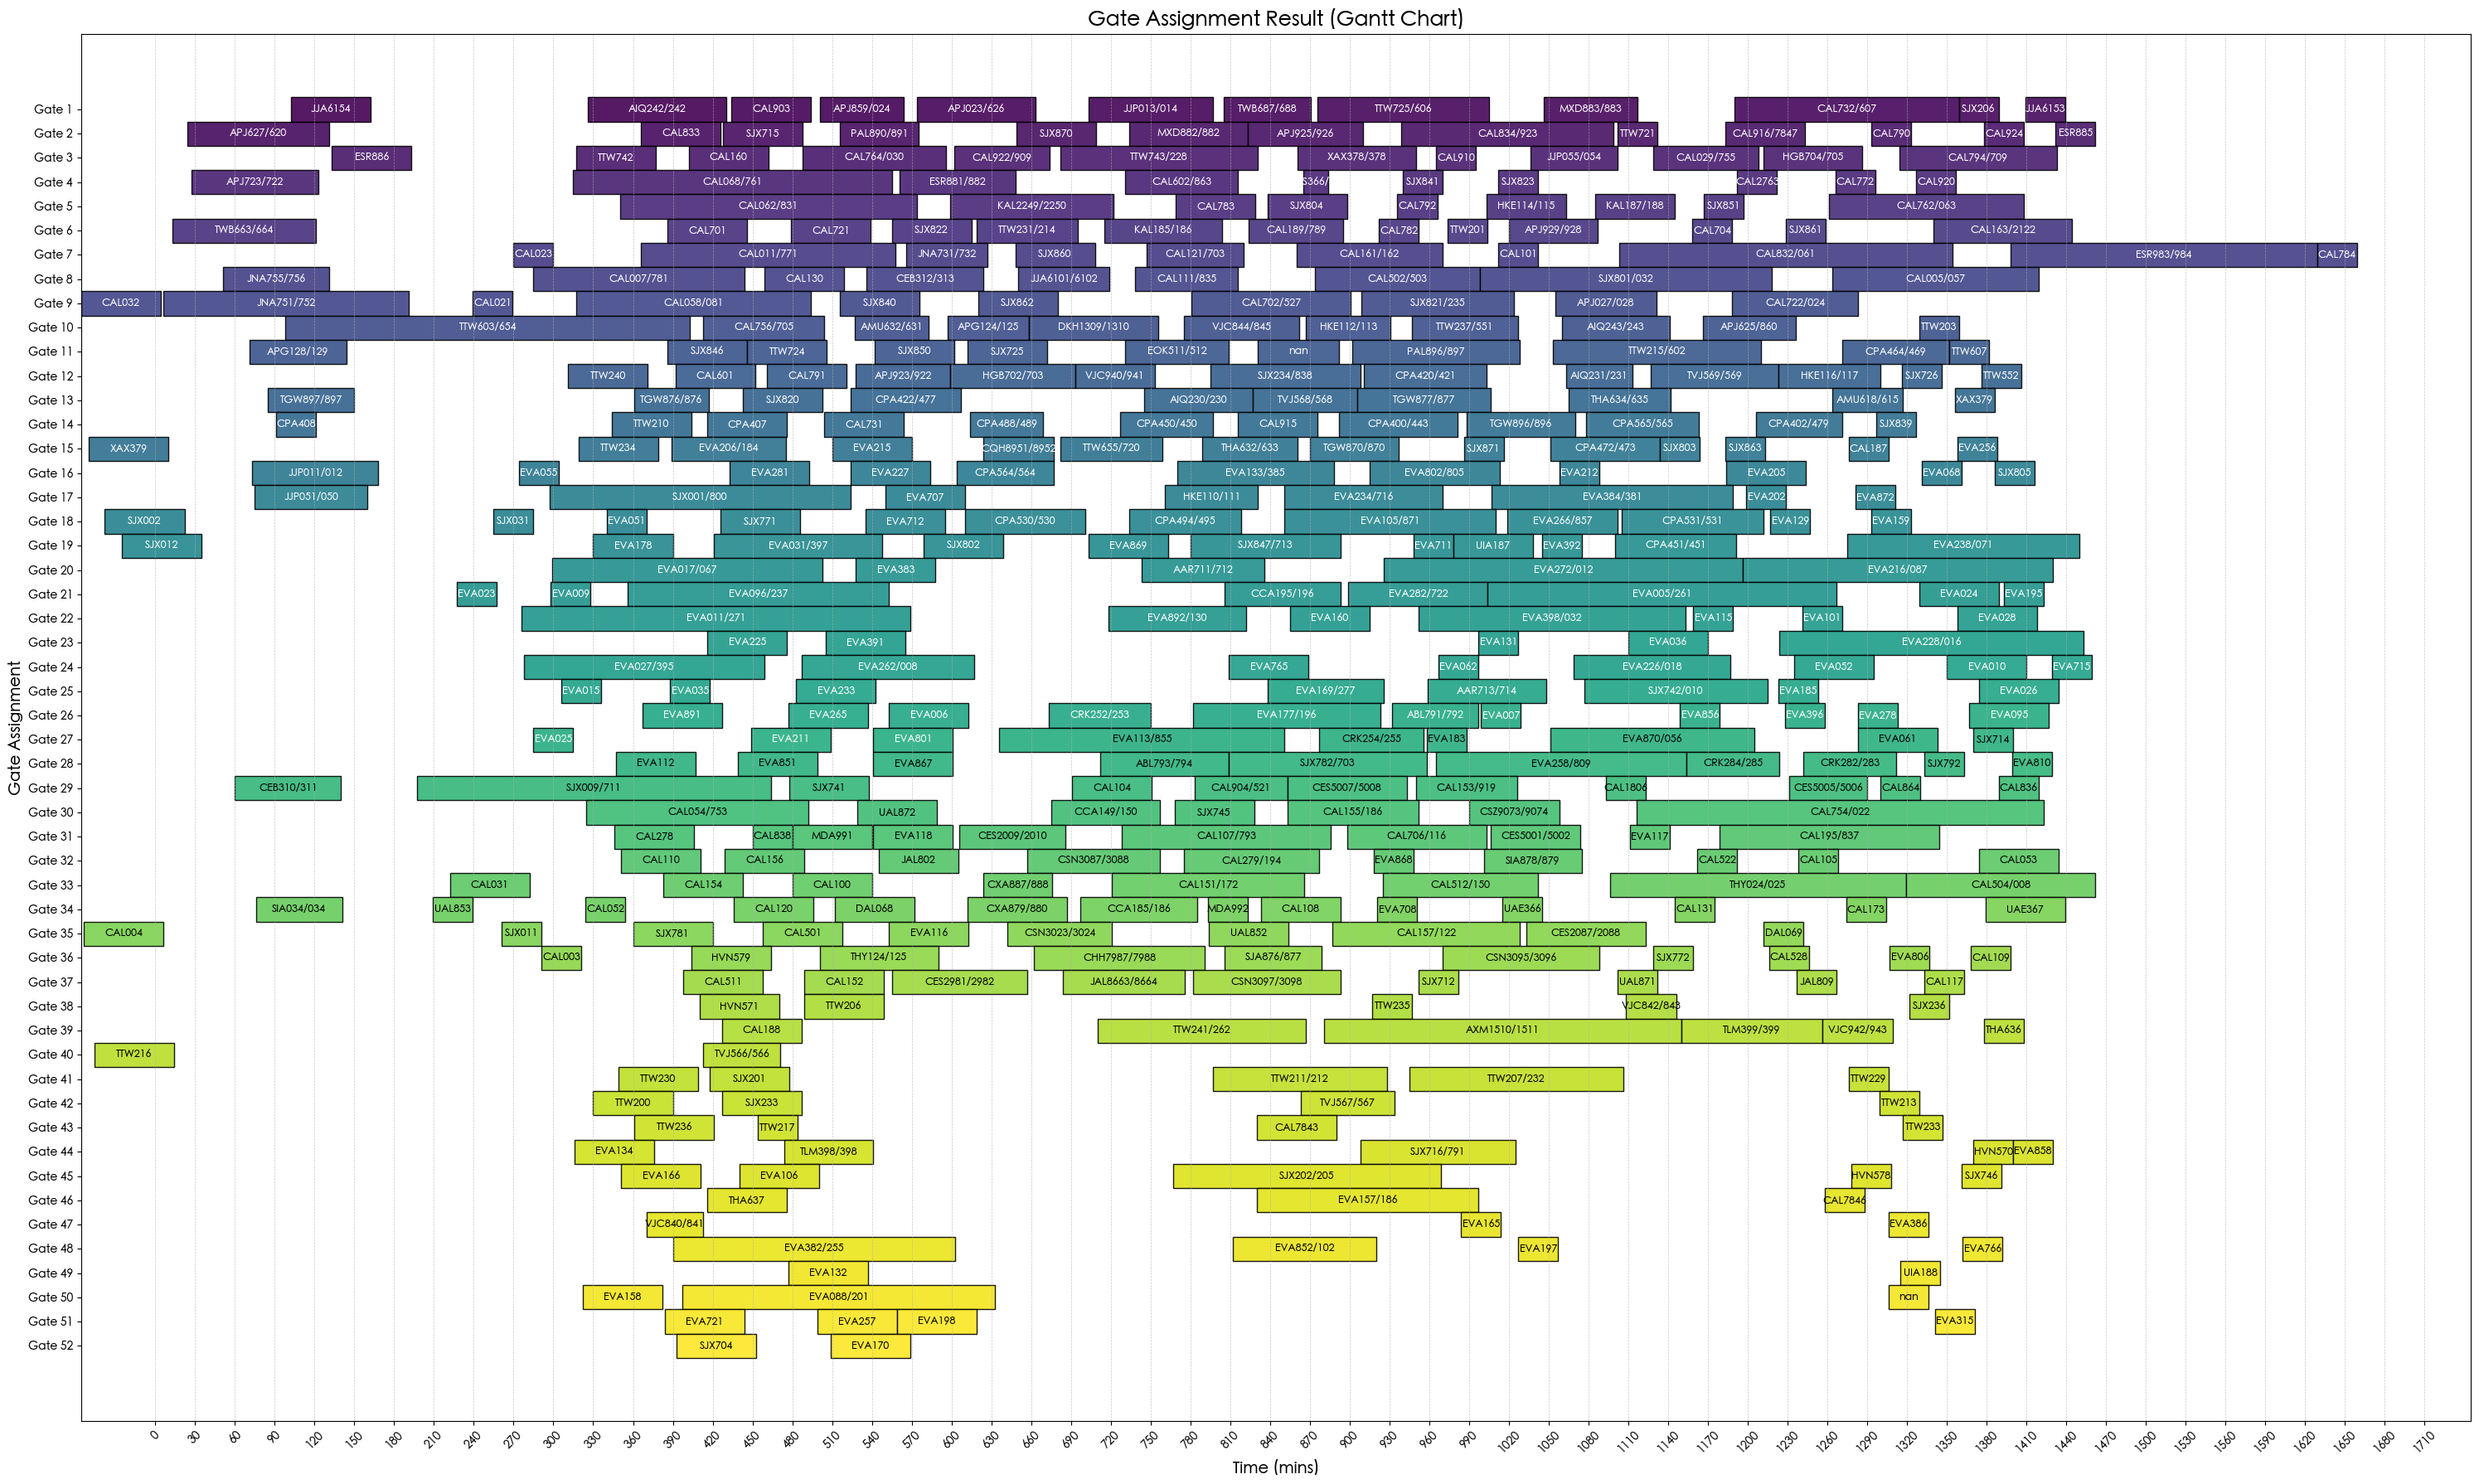

In [ ]:
# initialize Tabu Search 
TS_instance = TabuSearch(
    flights=flights,
    N=N,
    Wij=Wij,
    tabu_size=10,
    iterations=100
)

# calculate initial cost
print (f"Initial cost: {TS_instance.current_cost}")

# calculate initial number of flights assigned to apron
apron_count = sum(1 for flight in flights if flight.Y > 37)  # 停機坪的 gate 編號從 38 開始
print(f"Initial number of flights assigned to apron: {apron_count}")

# show initial assignment gantt
generate_result_csv(TS_instance.current_assignment, 'initial_results.csv')
draw_gantt('initial_results.csv', 'initial_gantt_chart.png')

Initial cost: 5097
Iteration 1 [NEW BEST]: 4880
Iteration 2 [NEW BEST]: 4815
Iteration 3 [NEW BEST]: 4735
Iteration 4 [NEW BEST]: 4684
Iteration 5 [NEW BEST]: 4644
Iteration 6 [NEW BEST]: 4604
Iteration 7 [NEW BEST]: 4566
Iteration 8 [NEW BEST]: 4486
Iteration 9 [NEW BEST]: 4406
Iteration 10 [NEW BEST]: 4342
Iteration 11 [NEW BEST]: 4302
Iteration 12 [NEW BEST]: 4211
Iteration 13 [NEW BEST]: 4153
Iteration 14 [NEW BEST]: 4073
Iteration 16 [NEW BEST]: 4041
Iteration 17 [NEW BEST]: 3966
Iteration 18 [NEW BEST]: 3933
Iteration 19 [NEW BEST]: 3908
Iteration 20 [NEW BEST]: 3828
Iteration 22 [NEW BEST]: 3820
Iteration 23 [NEW BEST]: 3750
Iteration 24 [NEW BEST]: 3720
Iteration 25 [NEW BEST]: 3680
Iteration 26 [NEW BEST]: 3656
Iteration 27 [NEW BEST]: 3616
Iteration 28 [NEW BEST]: 3589
Iteration 29 [NEW BEST]: 3558
Iteration 30 [NEW BEST]: 3546
Iteration 32 [NEW BEST]: 3518
Iteration 33 [NEW BEST]: 3469
Iteration 34 [NEW BEST]: 3432
Iteration 38 [NEW BEST]: 3406
Iteration 42 [NEW BEST]: 3361


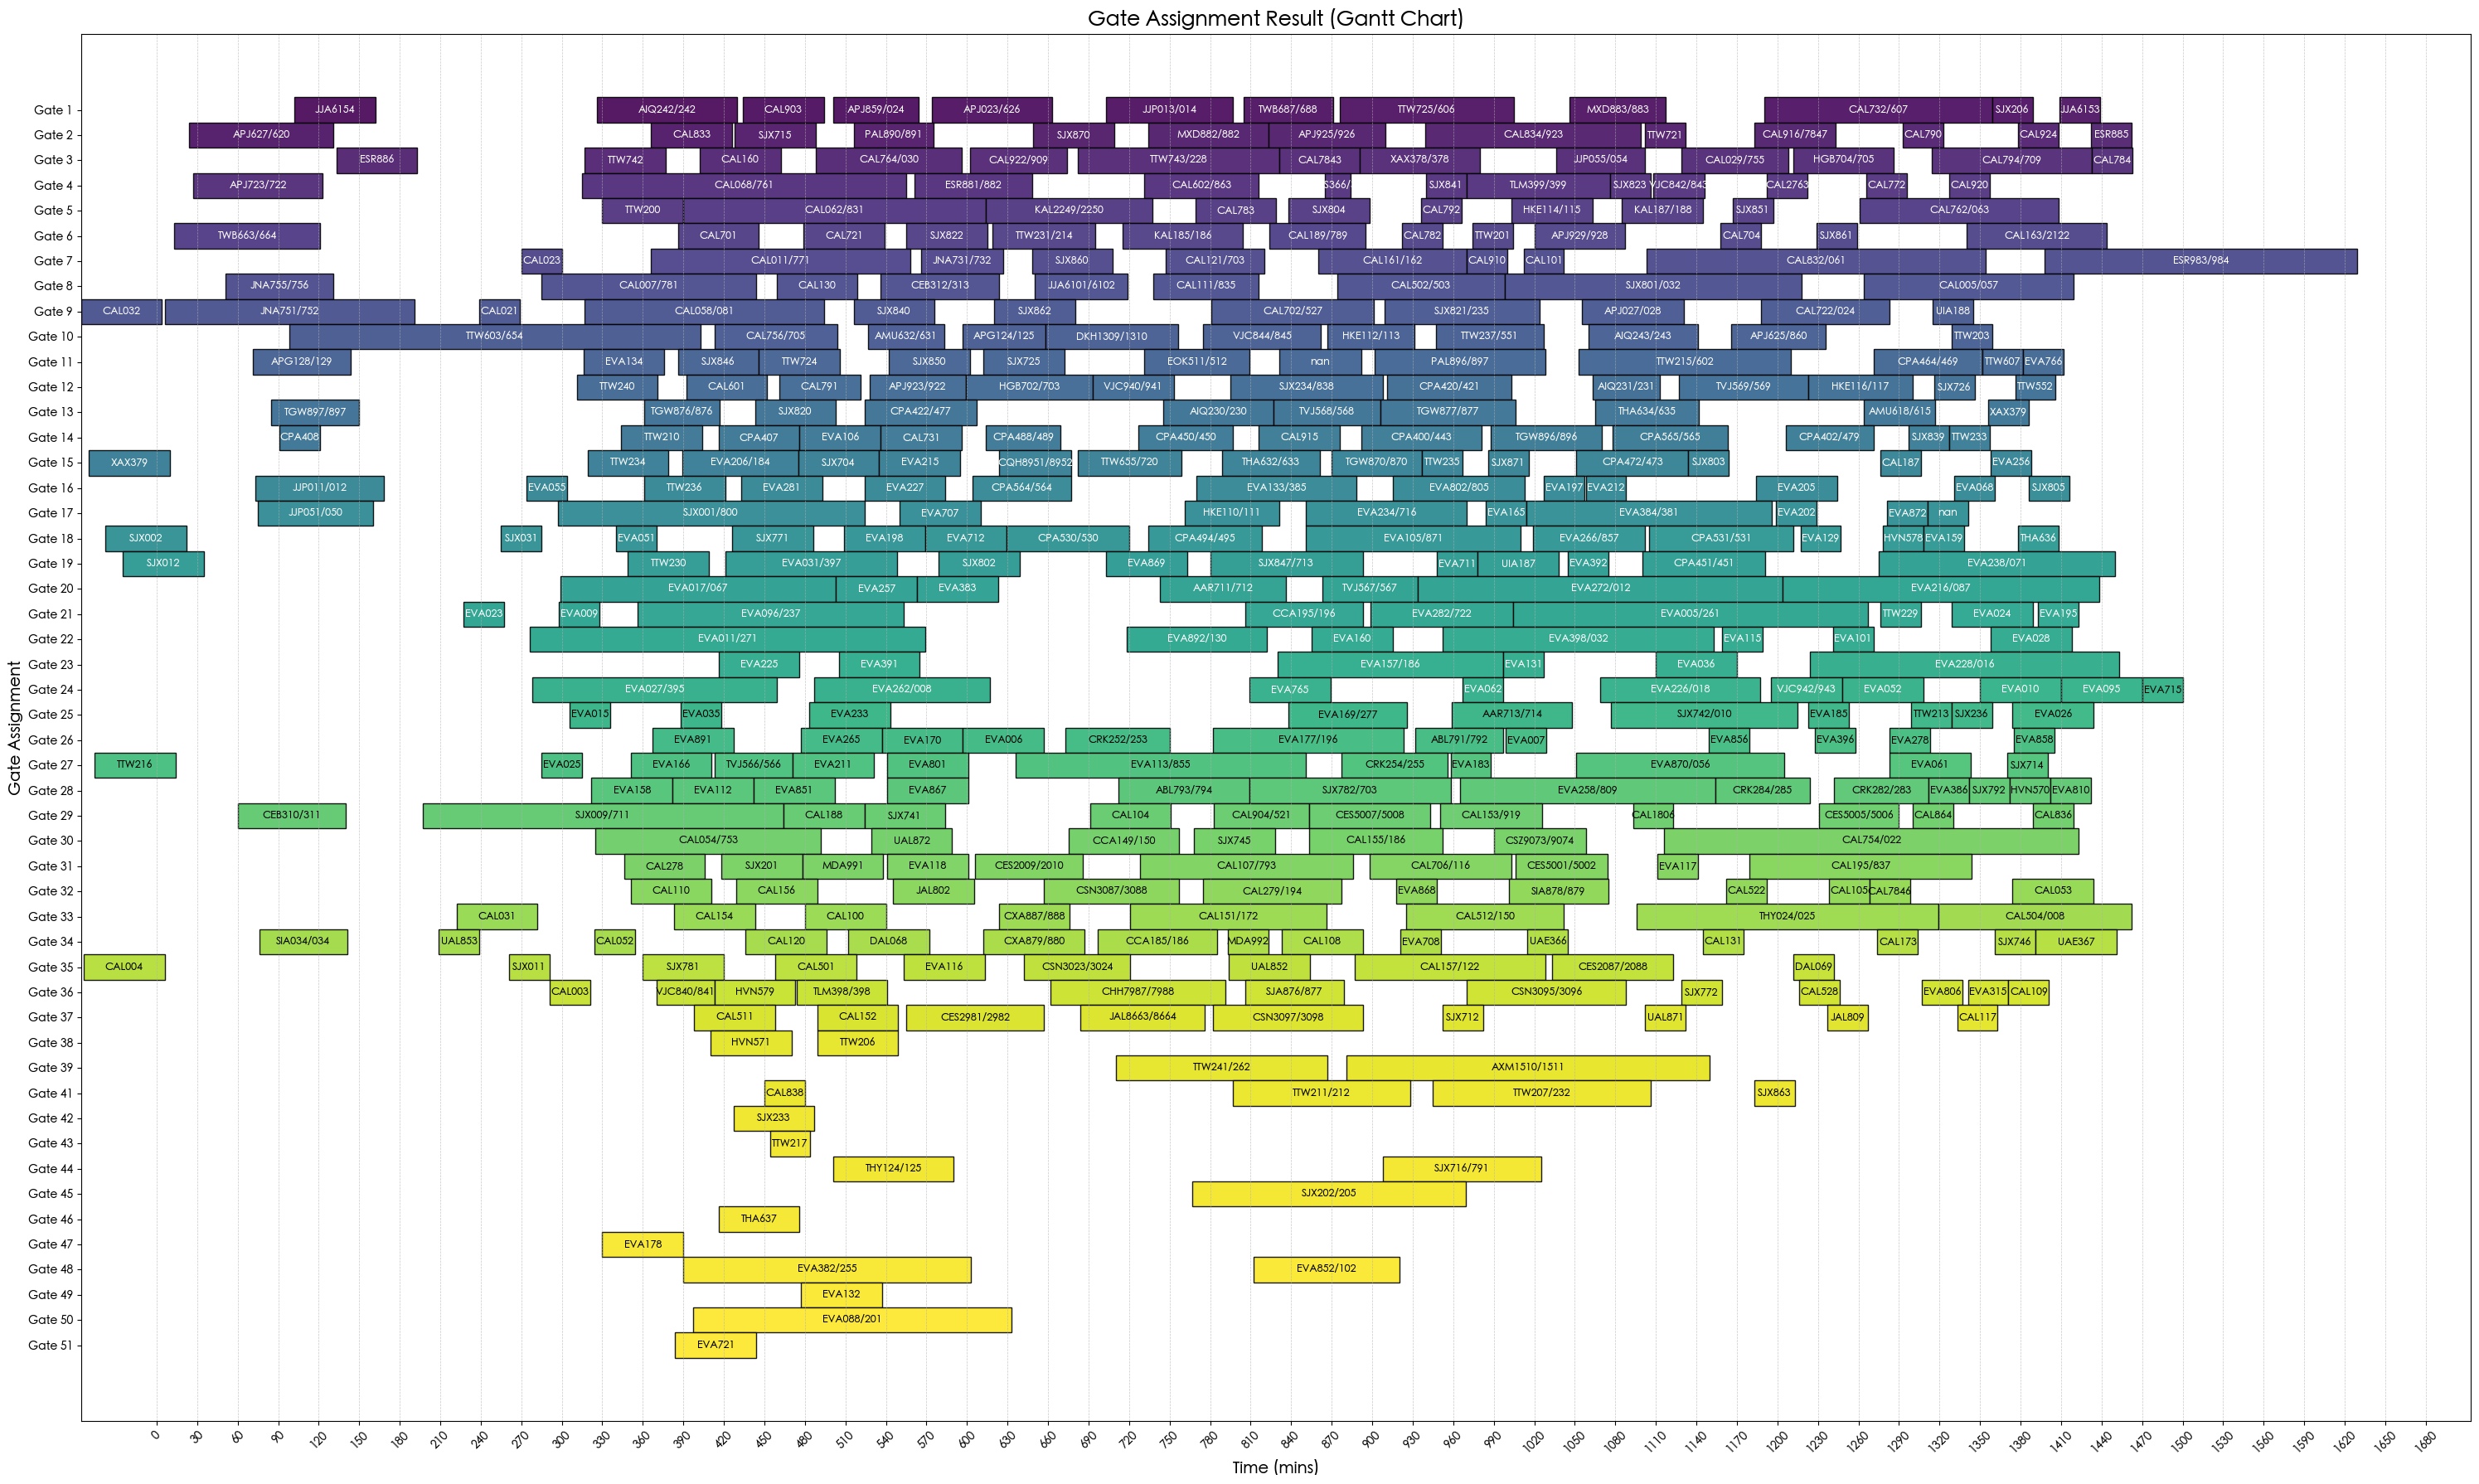

In [ ]:
# start optimization
TS_instance.optimize()

# print best cost
print("Best cost (total delay) (Tabu Search):", TS_instance.best_cost)

# count flights assigned to apron in the best assignment
apron_count_best = 0
for gate_idx, assigned_flights in TS_instance.best_assignment.items():
    if gate_idx > 37:  # 停機坪的 gate 編號從 38 開始
        apron_count_best += len(assigned_flights)

print(f"Number of flights assigned to apron in best assignment: {apron_count_best}")

generate_result_csv(TS_instance.best_assignment, 'best_results.csv')
draw_gantt('tabu_results.csv', 'tabu_gantt_chart.png')

In [ ]:
# run multiple times to get average performance
import time
tabu_best_costs = 0
optimize_times = 0
num_apron = 0
for i in range(50):
    TS_instance = TabuSearch(
        flights=flights,
        N=N,
        Wij=Wij,
        tabu_size=10,
        iterations=150
    )
    start_time = time.time()
    TS_instance.optimize()
    end_time = time.time()
    tabu_best_costs += TS_instance.best_cost
    optimize_times += (end_time - start_time)
    for gate_idx, assigned_flights in TS_instance.best_assignment.items():
        if gate_idx > 37:
            num_apron += len(assigned_flights)

Initial cost: 5097
Iteration 1 [NEW BEST]: 5087
Iteration 2 [NEW BEST]: 5036
Iteration 3 [NEW BEST]: 4961
Iteration 4 [NEW BEST]: 4909
Iteration 5 [NEW BEST]: 4815
Iteration 6 [NEW BEST]: 4735
Iteration 7 [NEW BEST]: 4683
Iteration 8 [NEW BEST]: 4651
Iteration 9 [NEW BEST]: 4571
Iteration 10 [NEW BEST]: 4498
Iteration 11 [NEW BEST]: 4418
Iteration 12 [NEW BEST]: 4361
Iteration 13 [NEW BEST]: 4324
Iteration 14 [NEW BEST]: 4244
Iteration 15 [NEW BEST]: 4237
Iteration 16 [NEW BEST]: 4221
Iteration 17 [NEW BEST]: 4199
Iteration 18 [NEW BEST]: 4180
Iteration 19 [NEW BEST]: 4141
Iteration 20 [NEW BEST]: 4103
Iteration 21 [NEW BEST]: 4064
Iteration 23 [NEW BEST]: 4047
Iteration 25 [NEW BEST]: 4045
Iteration 27 [NEW BEST]: 4012
Iteration 28 [NEW BEST]: 4005
Iteration 29 [NEW BEST]: 3970
Iteration 30 [NEW BEST]: 3941
Iteration 31 [NEW BEST]: 3891
Iteration 32 [NEW BEST]: 3872
Iteration 33 [NEW BEST]: 3870
Iteration 34 [NEW BEST]: 3830
Iteration 35 [NEW BEST]: 3790
Iteration 37 [NEW BEST]: 3777


In [8]:
print (f"average cost of 50 runs: {tabu_best_costs/50}")
print (f"average optimize time of 50 runs: {optimize_times/50}")
print (f"average number of apron flights of 50 runs: {num_apron/50}")

average cost of 50 runs: 3411.98
average optimize time of 50 runs: 17.35742360115051
average number of apron flights of 50 runs: 20.74
